# Sistemas de recomendação

O objetivo dos sistemas de recomendação é gerar recomendações para os usuários dados itens ou produtos relacionados que tenham interesse.

## Bibliotecas

In [3]:
import io
import numpy as np
import pandas as pd
import scipy.io as spio
from scipy.optimize import minimize
from matplotlib import pyplot as plt

## Dataset

Afim de implementar o algoritmo de filtragem colaborativa para um sistema de recomendação será utilizado um dataset que contém a classificações de filmes de 0 a 5 para diferentes usuários. O conjunto de dados consiste de 943 usuário e 1682 filmes. A matriz _Y_ armazena as classificações de 0 a 5, a matriz _R_ indica de um usuário forneceu uma classificação para o filme ou não, a matriz _X_ corresponde ao vetor de características para os filmes e a matriz _Theta_ corresponde ao vetor de parâmetros para cada usuário.

In [4]:
data = spio.loadmat('data/ex8_movies.mat', squeeze_me=True)
data_params = spio.loadmat('data/ex8_movieParams.mat', squeeze_me=True)

file = io.open('data/movie_ids.txt', encoding='ISO-8859-1')
lines = file.readlines()
movies = [' '.join(line.split()[1:]).strip() for line in lines]

In [11]:
Y = data['Y']
R = data['R'].astype(bool)
X = data_params['X']
Theta = data_params['Theta']
num_users = data_params['num_users']
num_movies = data_params['num_movies']
num_features = data_params['num_features']

In [12]:
#  A partir da matriz, é possível computar estatísticas como a avaliação média.
print('Avaliação média para filme 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :]]))

Avaliação média para filme 1 (Toy Story): 3.878319 / 5


### Visualização gráfica das notas dos filmes para os usuários

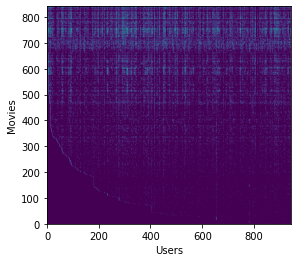

In [142]:
plt.figure()
plt.imshow(Y, aspect='equal', origin='upper', extent=(0, Y.shape[1], 0, Y.shape[0]/2.0))
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

In [14]:
#  Reduz o conjunto de dados para que a execucao seja mais rapida
num_users = 4
num_movies = 5
num_features = 3
X_red = X[:num_movies, :num_features]
Theta_red = Theta[:num_users, :num_features]
Y_red = Y[:num_movies, :num_users]
R_red = R[:num_movies, :num_users]

## Algoritmo de aprendizagem de filtragem colaborativa

### Função de custo e gradiente da filtragem colaborativa

A função de custo é dada pela seguinte expressão:

$$ J(x^{(i)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)} = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 $$

A função de custo é implementada na função _cofi\_cost\_func_ definida abaixo, o custo só é acumulado para o usuário caso ele tenha avaliado o filme.

Os gradientes da filtragem colaborativa para _X_ e _Theta_ são definidos pelas seguintes expressões:

$$ \frac{\partial{J}}{\partial{x_k^{(i)}}} = \sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial{J}}{\partial{\theta_k^{(j)}}} = \sum_{i:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) x_k^{(j)} $$

Os gradientes são implementados na função _cofi\_cost\_func_ para produzir os valores de _X\_grad_, uma matriz do mesmo tamanho de _X_, e _Theta\_grad_, uma matriz de mesmo tamanho de _Theta_. As duas matrizes são então combinadas na variávels _grad_.

In [17]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, Lambda):
    X = np.array(params[:num_movies*num_features]).reshape(num_features, num_movies).T.copy()
    Theta = np.array(params[num_movies*num_features:]).reshape(num_features, num_users).T.copy()
    
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # Função de custo
    J = (1 / 2) * np.sum((((X @ Theta.T) - Y) ** 2) * R)
    
    # Gradiente
    X_grad = (((X @ Theta.T) - Y) * R) @ Theta
    Theta_grad = (((X @ Theta.T) - Y) * R).T @ X

    grad = np.hstack((X_grad.T.flatten(), Theta_grad.T.flatten()))

    return J, grad

params = np.hstack((X_red.T.flatten(), Theta_red.T.flatten()))
J, grad = cofi_cost_func(params, Y_red, R_red, num_users, num_movies, num_features, 0)

print('Custo computado usando parâmetros pré-treinados: %f \n(valor deve ser próximo de 22.22)' % J)

Custo computado usando parâmetros pré-treinados: 22.224604 
(valor deve ser próximo de 22.22)


## Aprendizado de recomendações para filmes

Para o aprendizado de recomendação para os filmes primeiro é necessários definir avalições para alguns dos filmes do conjunto de dados.

In [19]:
ratings = np.zeros(len(movies))

ratings[0] = 4
ratings[97] = 2
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Avaliacoes do novo usuario:')

for i in np.where(ratings > 0)[0]:
    print('\tAvaliou %d para %s' % (ratings[i], movies[i]))

Avaliacoes do novo usuario:
	Avaliou 4 para Toy Story (1995)
	Avaliou 3 para Twelve Monkeys (1995)
	Avaliou 5 para Usual Suspects, The (1995)
	Avaliou 4 para Outbreak (1995)
	Avaliou 5 para Shawshank Redemption, The (1994)
	Avaliou 3 para While You Were Sleeping (1995)
	Avaliou 5 para Forrest Gump (1994)
	Avaliou 2 para Silence of the Lambs, The (1991)
	Avaliou 4 para Alien (1979)
	Avaliou 5 para Die Hard 2 (1990)
	Avaliou 5 para Sphere (1998)


Após definir as avaliações do usuários, deve-se juntar com as avaliações dos outros usuários produzindo a matriz _Y\_ratings_ e _R\_ratings_ e, então, normalizar os dados.

In [22]:
def normalize_ratings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(n):
        idx = (R[i,:]==1).nonzero()[0]
        if len(idx):
            Ymean[i] = np.mean(Y[i, idx])
            Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        else:
            Ymean[i] = 0.0
            Ynorm[i,idx] = 0.0

    return Ynorm, Ymean

Y_ratings = np.column_stack((ratings, Y))
R_ratings = np.column_stack((ratings, R)).astype(bool)
Ynorm, Ymean = normalize_ratings(Y, R)

Após o preprocessamento dos dados, o modelo de filtragem colaborativa é treinado para obter os parâmetros _X_ de _Theta_ para prever a avaliação de um filme por um usário.

In [127]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

X_rand = np.random.rand(num_movies, num_features)
Theta_rand = np.random.rand(num_users, num_features)

initial_parameters = np.hstack((X_rand.T.flatten(), Theta_rand.T.flatten()))
Lambda = 10

cost_func = lambda p: cofi_cost_func(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[0]
grad_func = lambda p: cofi_cost_func(p, Ynorm, R, num_users, num_movies, num_features, Lambda)[1]

result = minimize(cost_func, initial_parameters, method='CG', jac=grad_func, options={'disp': True, 'maxiter': 1000.0})
theta = result.x
cost = result.fun

         Current function value: 21265.642210
         Iterations: 1000
         Function evaluations: 1475
         Gradient evaluations: 1475


In [128]:
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

Após o treinamento do modelo, podemos consultar os resultados sobre as recomendações para o usuário.

In [137]:
p = X @ Theta.T
predictions = p[:, 0] + Ymean

pre=np.array([[idx, p] for idx, p in enumerate(predictions)])
post = pre[pre[:,1].argsort()[::-1]]
r = post[:,1]
ix = post[:,0]

print('\nRecomendacoes principais:')
for i in range(10):
    j = int(ix[i])
    print('\tPrevisão de avaliacao %.1f para %s' % (predictions[j], movies[j]))

print('\nAvaliacoes originais fornecidas:')
for i in range(len(ratings)):
    if ratings[i] > 0:
        print('\tAvaliou %d para %s' % (ratings[i], movies[i]))


Recomendacoes principais:
	Previsão de avaliacao 8.8 para Great Escape, The (1963)
	Previsão de avaliacao 8.3 para Corrina, Corrina (1994)
	Previsão de avaliacao 7.9 para Babe (1995)
	Previsão de avaliacao 7.9 para Young Frankenstein (1974)
	Previsão de avaliacao 7.7 para Secret Garden, The (1993)
	Previsão de avaliacao 7.1 para Fifth Element, The (1997)
	Previsão de avaliacao 7.1 para Four Weddings and a Funeral (1994)
	Previsão de avaliacao 7.1 para Terminator, The (1984)
	Previsão de avaliacao 7.1 para Close Shave, A (1995)
	Previsão de avaliacao 7.0 para Happy Gilmore (1996)

Avaliacoes originais fornecidas:
	Avaliou 4 para Toy Story (1995)
	Avaliou 3 para Twelve Monkeys (1995)
	Avaliou 5 para Usual Suspects, The (1995)
	Avaliou 4 para Outbreak (1995)
	Avaliou 5 para Shawshank Redemption, The (1994)
	Avaliou 3 para While You Were Sleeping (1995)
	Avaliou 5 para Forrest Gump (1994)
	Avaliou 2 para Silence of the Lambs, The (1991)
	Avaliou 4 para Alien (1979)
	Avaliou 5 para Die Har